## Solution summary

Train and Test mean pooled image embeddings are extracted from a swin large image regression model.<br/>
The extracted embeddings are then concatenated with the season and growth stage categorical features to create final train and test sets.<br/>
An xgboost regressor is trained on the data concatenation via StratifiedKFold cross validation and the average of predictions over all folds is taken for the final test predictions.

#### Source of conflict

This solution employs pre and postprocessing with the use of the damage feature column but **DOESN'T use the damage feature itself for model training**. <br/>
As per the goal outlined for the competition, **Since most claims are related to drought, this challenge will ask participants to predict drought damage from smartphone images of crops taken in the past**, Zindi's [communique here](https://zindi.africa/competitions/cgiar-eyes-on-the-ground-challenge/discussions/18699) doesn't clearly address many issues to do with the damage feature as Reacher's comment under that discussion states. Damage isn't a label leak as it communicates nothing as to how extents were arrived at and can't be used to infer the exact extent value itself. I thus have one of my submissions that trains only on DR affected images and predict on only DR images on the test set, leaving the rest as zeros. <br/>
Because there's no clear explanation in this regard, I trained my other model (similar approach as this one) without employing the damage feature column in the pre and postprocessing steps used in this solution.

In [1]:
import os
from glob import glob
from dataclasses import dataclass
import gc
import numpy as np
from numpy.linalg import norm
import pandas as pd
import PIL
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
from transformers import ViTImageProcessor, AutoModel
from tqdm import tqdm
import xgboost as xgb
import timm

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
from sklearn.metrics import mean_squared_error

In [2]:
## check mac gpu availability
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"MPS activated?: {torch.backends.mps.is_built()}")

MPS available: True
MPS activated?: True


In [6]:
@dataclass
class Config:
	device: torch.device = torch.device("mps") # change to from "mps" to "cuda" if using a nvidia gpu
	data_dir: os.PathLike = "./data/"
	n_folds: int = 4
	seed: int = 43098
	batch_size: int = 16
	epochs: int = 3
	eta: float = 3e-4


def RMSE(y_pred, true_value):
	"""Computes the root mean squared error."""
	return np.sqrt(mean_squared_error(y_pred, true_value))

In [7]:
## convert image file extensions to lowercase
## uncomment to last two lines for use. Ensure a proper base path (parent dir) to train and test image folders is provided

def file_ext_lowercase(path: os.PathLike):
	"""Lower case file extension."""
	for filename in os.listdir(path):
		if filename.endswith('.JPG'):
			# Generate the new filename with lowercase extension
			new_filename = os.path.join(path, filename.lower())
			# Rename the file
			os.rename(os.path.join(path, filename), new_filename)

#file_ext_lowercase(os.path.join(Config.data_dir, "train"))
#file_ext_lowercase(os.path.join(Config.data_dir, "test"))

In [8]:
train_df = pd.read_csv(os.path.join(Config.data_dir, "Train.csv"))
test_df = pd.read_csv(os.path.join(Config.data_dir, "Test.csv"))
print(f"Train data shape: {train_df.shape}, Num train images: {len(os.listdir(os.path.join(Config.data_dir, 'train')))}\n")
print(f"Train df:\n{train_df.head()}\n")
print(f"Test data shape: {test_df.shape}, Num test images: {len(os.listdir(os.path.join(Config.data_dir, 'test')))}\n")
print(f"Test df:\n{test_df.head()}")


Train data shape: (26068, 6), Num train images: 26068

Train df:
              ID                        filename growth_stage damage  extent  \
0  ID_1S8OOWQYCB  L427F01330C01S03961Rp02052.jpg            S     WD       0   
1  ID_0MD959MIZ0      L1083F00930C39S12674Ip.jpg            V      G       0   
2  ID_JRJCI4Q11V      24_initial_1_1463_1463.JPG            V      G       0   
3  ID_DBO3ZGI1GM  L341F00167C01S00324Rp14178.jpg            M     DR      60   
4  ID_ORZLWTEUUS      L1084F02394C39S13931Ip.jpg            V      G       0   

   season  
0  SR2020  
1  SR2021  
2  LR2020  
3  SR2020  
4  SR2021  

Test data shape: (8663, 5), Num test images: 8663

Test df:
              ID                         filename growth_stage damage  season
0  ID_ROOWKB90UZ   L122F00315C01S02151Rp04021.jpg            V     WD  SR2020
1  ID_PTEDRY0CYM  L1089F03254C01S08845Rp25119.jpg            F     WD  LR2021
2  ID_5WJXDV96R4   L365F01913C39S12578Rp42918.jpg            V     WD  SR2021
3  ID_DM4

Mean damage extent: 7.096056467699862
Standard Deviation of damage extent: 18.61287150126672


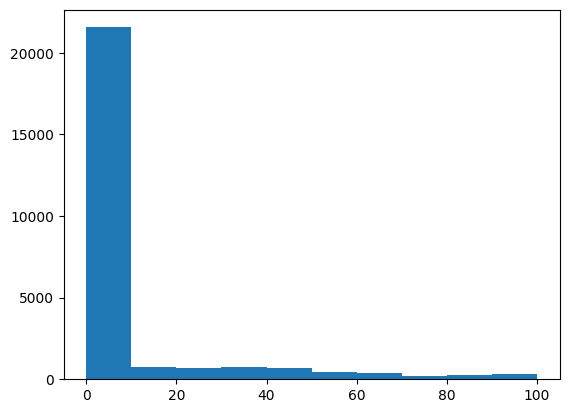

In [10]:
## extent distribution over entire dataset
print(f"Mean damage extent: {np.mean(train_df['extent'].values)}")
print(f"Standard Deviation of damage extent: {np.std(train_df['extent'].values)}")
plt.hist(train_df["extent"]);

In [11]:
# class distributions by group
groups = train_df.groupby("season")["extent"]

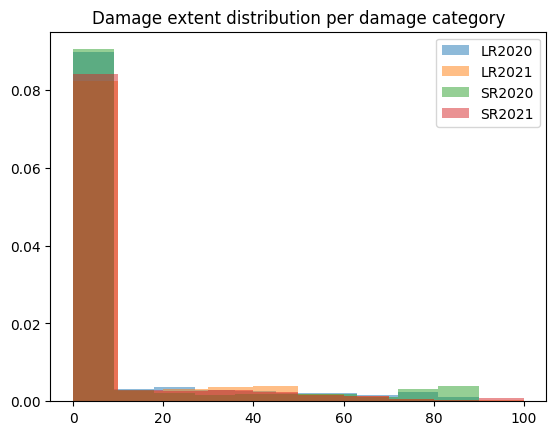

In [12]:
extent = {}
test_df["extent"] = -1
for g_name, group in groups:
	extent[g_name] = np.mean(group)

for g_name, group in groups:
	plt.title("Damage extent distribution per damage category")
	plt.hist(group, alpha=0.5, density=True, label=g_name)
plt.legend()

In [13]:
train_df.describe()

,extent
count,26068.000000
mean,7.096056
std,18.613229
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,100.000000


In [14]:
print(train_df['growth_stage'].value_counts())
print(train_df['season'].value_counts())

growth_stage
V    10015
M     6664
F     6164
S     3225
Name: count, dtype: int64
season
SR2021    9927
LR2021    7945
SR2020    6163
LR2020    2033
Name: count, dtype: int64


In [15]:
# match image filenames to full image path
train_df["images"] = train_df["filename"].apply(lambda x: os.path.join(Config.data_dir, "train", x))
test_df["images"] = test_df["filename"].apply(lambda x: os.path.join(Config.data_dir, "test", x))

# rename files with mismatching names and file extensions.
rename_idx = list(train_df.loc[train_df["images"].apply(lambda x: "Copy" in x)].index)
for idx in rename_idx:
	corrected_fname = train_df.loc[idx, "images"].split(" - ")[0]+".jpg"
	if os.path.isfile(os.path.join(Config.data_dir, "train", corrected_fname)):
		train_df.loc[idx, "images"] = corrected_fname
	else:
		train_df.drop([idx], axis=0, inplace=True)

train_df["images"] = train_df["images"].apply(lambda x: x.replace(".JPG", ".jpg"))
test_df["images"] = test_df["images"].apply(lambda x: x.replace(".JPG", ".jpg"))
train_df = train_df.drop(["filename"], axis=1).reset_index(drop=True)
test_df = test_df.drop(["filename"], axis=1)
print(train_df.shape)

(26068, 6)


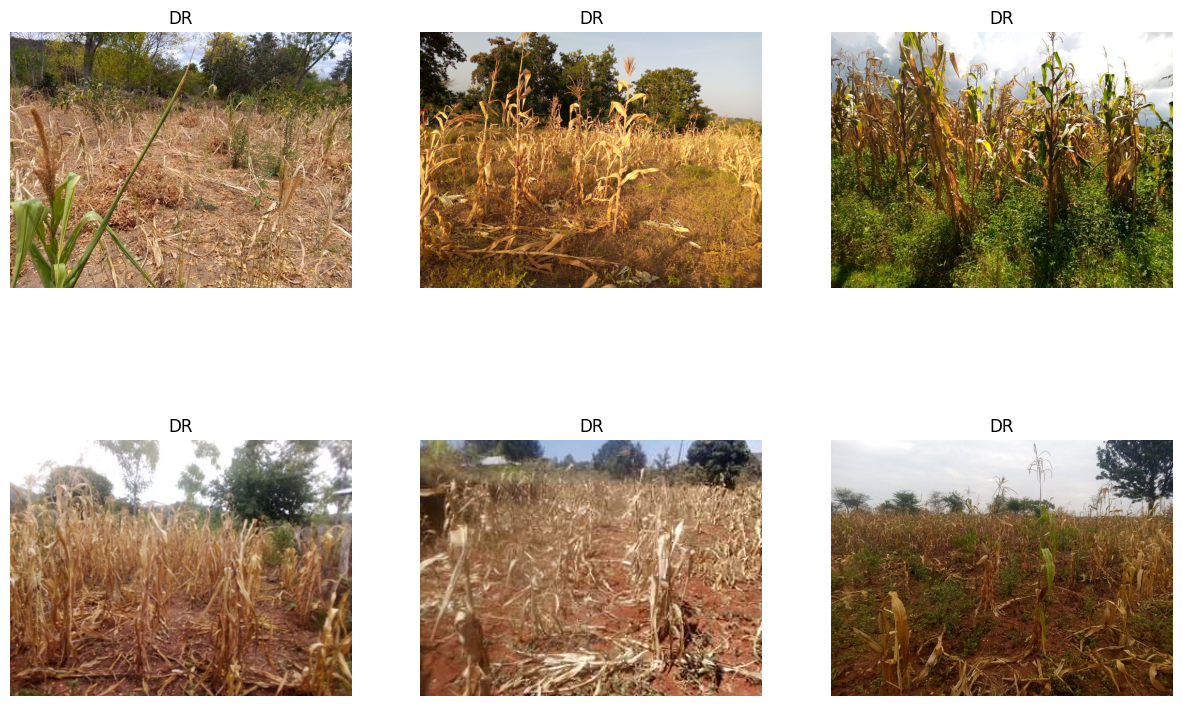

In [16]:
def plot_images(
    df: pd.DataFrame,
    n_samples: int,
    cat: str,
    extent: int,
    seed: int,
    verbose: bool=False
):
    """Visualize a sample of images for a given damage category."""
    plot_list = df[(df["damage"] == cat) & (df["extent"] >= extent)].sample(n_samples, random_state=seed)["images"].tolist()
    if verbose:
        print(f"Sampled Image IDs:\n{plot_list}")

    labels = [cat for i in range(len(plot_list))]
    size = np.sqrt(n_samples)
    if int(size) * int(size) < n_samples:
        size = int(size) + 1

    plt.figure(figsize=(15, 15))
    for idx, (image_id, label) in enumerate(zip(plot_list, labels)):
        plt.subplot(size, size, idx + 1)
        image = cv2.imread(image_id)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.title(label, fontsize=12)
        plt.axis("off")

    plt.show()

plot_images(df=train_df, n_samples=6, cat="DR", extent=70, seed=np.random.randint(100), verbose=False)
## ND type images similar to DR, DS images
## Some PS and WD, DR images seem to have similar spatial characteristics for some extent values
## PS and G are almost indistinguishable for images further out of focus with smaller damage extents

In [17]:
## Relabel no DR damage images to 0 greatly improves model learning ability to predict drought damaged crops
## train on only DR images
train_df.loc[(train_df["damage"] != "DR"), "extent"] = 0.0
train_df = train_df[train_df["damage"] == "DR"].reset_index(drop=True)
train_df["extent"].value_counts()

extent
10     729
30     727
40     696
20     690
50     445
60     388
90     300
80     291
70     199
100     45
0        6
Name: count, dtype: int64

In [18]:
## create folds
skfold = StratifiedKFold(n_splits=Config.n_folds, shuffle=True, random_state=Config.seed)
for i, (train_idx, val_idx) in enumerate(skfold.split(train_df, train_df["extent"]), 1):
	train_df.loc[val_idx, "fold"] = int(i)

train_df.head()

,ID,growth_stage,damage,extent,season,images,fold
0,ID_DBO3ZGI1GM,M,DR,60,SR2020,../data/train/L341F00167C01S00324Rp14178.jpg,1.0
1,ID_BVNP8C4M1N,M,DR,40,LR2021,../data/train/L331F04678C01S11060Rp30683.jpg,1.0
2,ID_MFL3FVUKDA,F,DR,60,LR2021,../data/train/L133F00737C01S06945Rp25674.jpg,1.0
3,ID_NFYJ8T2V5W,M,DR,20,SR2020,../data/train/L432F01720C01S04931Rp13768.jpg,4.0
4,ID_C74KHW4OK5,M,DR,50,SR2020,../data/train/L133F03014C01S00293Rp10017.jpg,3.0


In [19]:
train_df["fold"].value_counts()

fold
1.0    1129
4.0    1129
3.0    1129
2.0    1129
Name: count, dtype: int64

### Extract Image Embeddings

Extract image embeddings per damage category using different pretrained vision models

In [21]:
swin_model = timm.create_model(
    "swin_large_patch4_window7_224",
    pretrained=True,
    num_classes=0,
)

/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [22]:
data_config = timm.data.resolve_model_data_config(swin_model)
data_config

{'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 0.9,
 'crop_mode': 'center'}

In [23]:
class ImageDataset(Dataset):
	"""CGIAR maize dataset."""
	def __init__(self, data_df, processor, model, timm_data_cfg=False, verbose=False):
		self.data_df = data_df
		self.processor = processor
		self.model = model
		self.timm_cfg = timm_data_cfg

	def __len__(self):
		return self.data_df.shape[0]

	def __getitem__(self, idx):
		image_path = self.data_df.loc[idx, "images"]
		image = PIL.Image.open(image_path).convert("RGB")
		
		if self.timm_cfg:
			# get model specific transforms (normalization, resize)
			data_config = timm.data.resolve_model_data_config(self.model)
			transforms = timm.data.create_transform(**data_config, is_training=False)
			return transforms(image).squeeze(0)
		else:
			image = self.processor(image, return_tensors="pt").pixel_values[0]
			return image


def get_dataloaders(train_df, test_df, processor, model, batch_size, timm_data_cfg=False):
	"""Get ImageDataset data generators."""
	train_df = train_df[["images"]]
	test_df = test_df[["images"]]
	train_dataset = ImageDataset(train_df, processor, model, timm_data_cfg)
	test_dataset = ImageDataset(test_df, processor, model, timm_data_cfg)
	# create dataloaders
	train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
	test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

	return train_dataloader, test_dataloader


def embeddings_to_disk(embeddings: np.ndarray, filename: str):
	"""Save embeddings to disk as numpy arrays."""
	np.save(filename+".npy", embeddings)
	return 


def get_embeddings(model, data_loader, batch_size, device, is_timm_model=False, split="train", verbose=True):
	"""Extract embeddings from input model."""
	model = model.to(device)
	model.eval()
	if split=="train":
		train_image_features = []
		for batch in tqdm(data_loader, total=len(data_loader)):
			if is_timm_model:
				with torch.no_grad():
					output = model.forward_features(batch.to(device))
					image_embeddings = model.forward_head(output, pre_logits=True)
			else:
				with torch.no_grad():
					image_embeddings = model(batch.to(device)).last_hidden_state
					image_embeddings = torch.mean(image_embeddings, 1)

			image_embeddings = image_embeddings.squeeze(0).detach().cpu().numpy()
			train_image_features.extend(image_embeddings)
		train_image_features = np.array(train_image_features)
		if verbose:
			print(f"Train embeddings shape: {train_image_features.shape}")
		
		return train_image_features

	else: # split == "test"
		test_image_features = []
		for batch in tqdm(data_loader, total=len(data_loader)):
			if is_timm_model:
				with torch.no_grad():
					output = model.forward_features(batch.to(device))
					image_embeddings = model.forward_head(output, pre_logits=True)
			else:
				with torch.no_grad():
					image_embeddings = model(batch.to(device)).last_hidden_state
					image_embeddings = torch.mean(image_embeddings, 1)
			
			image_embeddings = image_embeddings.squeeze(0).detach().cpu().numpy()
			test_image_features.extend(image_embeddings)

		test_image_features = np.asarray(test_image_features)
		if verbose:
			print(f"Test embeddings shape: {test_image_features.shape}")

		return test_image_features


train_dataloader, test_dataloader = get_dataloaders(train_df, test_df, None, swin_model, Config.batch_size, timm_data_cfg=True)

In [36]:
# Step run only once & embeddings saved to disk
## uncomment all to rerun else use existing embeddings under the embeddings dir
"""
train_embeddings = get_embeddings(swin_model, train_dataloader, Config.batch_size, Config.device, is_timm_model=True, split="train")
test_embeddings = get_embeddings(swin_model, test_dataloader, Config.batch_size, Config.device, is_timm_model=True, split="test")

## Save embeddings to disk
if not os.path.isdir("./embeddings"):
	os.mkdir("./embeddings")

embeddings_to_disk(train_embeddings, "./embeddings/swinl_dr_only_train_embeddings_maxpool")
embeddings_to_disk(test_embeddings, "./embeddings/swinl_dr_only_test_embeddings_maxpool")

del train_embeddings
del test_embeddings
del train_dataloader
del test_dataloader
gc.collect()
"""

In [24]:
train_features = np.load("./embeddings/swinl_dr_only_train_embeddings_maxpool.npy")
test_features = np.load("./embeddings/swinl_dr_only_test_embeddings_maxpool.npy")
print(train_features.shape, test_features.shape)

(4516, 1536) (8663, 1536)


In [25]:
train_df = train_df.drop(["ID", "images", "damage"], axis=1)
test_ids = test_df["ID"]
test_df = test_df.drop(["images", "ID", "extent", "damage"], axis=1)
train_df = pd.get_dummies(train_df, columns=["growth_stage", "season"])
test_df = pd.get_dummies(test_df, columns=["growth_stage", "season"])
test_features = np.concatenate([test_features, test_df.values], axis=1)

In [26]:
## model training
scores = []
predictions = []

for fold in range(1, Config.n_folds+1):
	print(f"======= Fold {fold}========")
	df_train = train_df[train_df["fold"] != fold]
	df_val = train_df[train_df["fold"] == fold]

	train_embeddings = train_features[list(df_train.index), :]
	train_embeddings = np.concatenate([train_embeddings, df_train.iloc[:, 2:].values], axis=1)
	target = df_train["extent"]
	val_target = df_val["extent"]
	

	val_embeddings = train_features[list(df_val.index), :]
	val_embeddings = np.concatenate([val_embeddings, df_val.iloc[:, 2:].values], axis=1)
	
	print(f"train_shape: {train_embeddings.shape}\nval_shape: {val_embeddings.shape}\ntest_shape: {test_features.shape}")
	xgb_model = xgb.XGBRegressor(
		n_estimators=350, 
		max_depth=5,
		max_leaves=150,
		eval_metric="rmse",
		objective="reg:squarederror",
		colsample_bytree=0.9,
		subsample=0.9,
		reg_alpha=1.5,
		learning_rate=0.143,
		base_score=0.0,
		random_state=Config.seed
	)

	xgb_model.fit(train_embeddings, target)
	val_preds = xgb_model.predict(val_embeddings)
	test_preds = xgb_model.predict(test_features)
	score = RMSE(val_target, val_preds)
	scores.append(score)
	print(f"Fold {fold} RMSE: {score}")
	predictions.append(test_preds)


======= Fold 1========
train_shape: (3387, 1544)
val_shape: (1129, 1544)
test_shape: (8663, 1544)


/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 1 RMSE: 17.13807142501287
======= Fold 2========
train_shape: (3387, 1544)
val_shape: (1129, 1544)
test_shape: (8663, 1544)


/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 2 RMSE: 17.369517828941138
======= Fold 3========
train_shape: (3387, 1544)
val_shape: (1129, 1544)
test_shape: (8663, 1544)


/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 3 RMSE: 17.203260095150025
======= Fold 4========
train_shape: (3387, 1544)
val_shape: (1129, 1544)
test_shape: (8663, 1544)


/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 4 RMSE: 16.526795639034948


In [27]:
np.mean(scores)

17.059411247034745

In [28]:
sub_df = pd.read_csv(os.path.join(Config.data_dir, "Test.csv"))
sub_df["extent"] = np.mean(predictions, 0)
sub_df.loc[(sub_df["extent"] < 0), "extent"] = 0
non_dr_images = list(sub_df[sub_df["damage"] != "DR"].index)
for idx in non_dr_images:
	sub_df.loc[idx, "extent"] = 0.0

sub_df[["ID", "extent"]].to_csv("sub_xgb_swinl_max_emb_DR_only.csv", index=False)
sub_df[["ID", "extent"]].head()

,ID,extent
0,ID_ROOWKB90UZ,0.0
1,ID_PTEDRY0CYM,0.0
2,ID_5WJXDV96R4,0.0
3,ID_DM4AQLXXYG,0.0
4,ID_V6YTIT7I2S,0.0
